In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
import torchvision.datasets as datasets

transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=4, shuffle=False)

In [ ]:
len(mnist_trainset)
type(mnist_trainset)

torchvision.datasets.mnist.MNIST

LABEL: 1

IMAGE PIXEL ARRAY:
 <PIL.Image.Image image mode=L size=28x28 at 0x7CB60CFBA350>


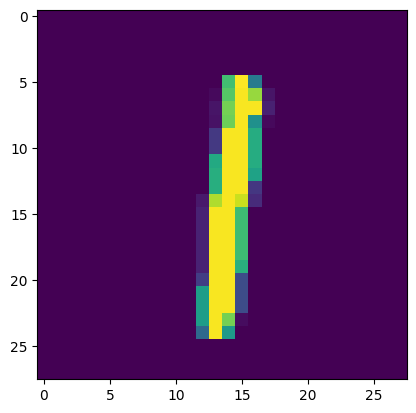

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# You can put between 0 to 59999 here
index = 40

# Set number of characters per row when printing
np.set_printoptions(linewidth=320)

# Print the label and image
print(f'LABEL: {mnist_trainset.__getitem__(index)[1]}')
print(f'\nIMAGE PIXEL ARRAY:\n {mnist_trainset.__getitem__(index)[0]}')

# Visualize the image
plt.imshow(mnist_trainset.__getitem__(index)[0])

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512,10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.
    acc = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()


        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [ ]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 1000 loss: 2.3022861025333405
  batch 2000 loss: 2.301105772972107
  batch 3000 loss: 2.298769552707672
  batch 4000 loss: 2.3012812614440916
  batch 5000 loss: 2.2985592193603517
  batch 6000 loss: 2.3014400453567503
  batch 7000 loss: 2.3012797544002535
  batch 8000 loss: 2.301996893167496
  batch 9000 loss: 2.3013648171424865
  batch 10000 loss: 2.3034223799705504
  batch 11000 loss: 2.299433210372925
  batch 12000 loss: 2.3035750155448915
  batch 13000 loss: 2.3031474494934083
  batch 14000 loss: 2.3017159514427186
  batch 15000 loss: 2.3036071438789367
LOSS train 2.3036071438789367 valid 2.299274444580078
EPOCH 2:
  batch 1000 loss: 2.300747334241867
  batch 2000 loss: 2.3002480518817903
  batch 3000 loss: 2.3007548253536223
  batch 4000 loss: 2.303999205350876
  batch 5000 loss: 2.29958197593689
  batch 6000 loss: 2.301960282325745
  batch 7000 loss: 2.3033778479099274
  batch 8000 loss: 2.2998592534065248
  batch 9000 loss: 2.302435200214386
  batch 10000 loss: 

# Penjelasan Model
Ini merupakan model squensial dengan input linear 28*28 dan output linear juga dengan 10 kelas output sesuai dengan kelas MNIST. Terdapat hidden layer ReLU dan Linear pada model ini. Model ini menggunakan loss function CrossEntropy dan Optimizer SGD dengan learning rate 0.001 dan momenntum 0.9. Model ini ditrain sebanyak 5 kali epoch dengan satu epoch memiliki jumlah batch 15000, karena satu batch terdapat 4 data.